In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgboost import XGBClassifier

import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_decision_forests as tfdf

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

pd.set_option('display.max_columns',20)
pd.set_option('display.max_rows',None)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

train_df = pd.read_csv('/kaggle/input/titanic/train.csv')
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

train_df.head(10)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [2]:
#Preprocessing data 
def preprocess(df):
    df = df.copy()
    
    def deck(x):
        if(pd.isna(x)):
            return "Unknown"
        else:
            return x[0]
        
    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    
    def ticket_number(x):
        if x == 'LINE':
            return 0
        else:
            return x.split(" ")[-1]
        
    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])
    
    def title(x):
        return x.split(", ")[1].split(".")[0]
    

    
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df["Deck"] = df["Cabin"].apply(deck)
    df["FamilySize"] = df["SibSp"] + df["Parch"]
    df['Fare'].fillna(df['Fare'].mean(), inplace=True)
    df['Fare_Per_Person']=df['Fare']/(df['FamilySize']+1)
    df["Title"] = df["Name"].apply(title)
    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number).astype('int64')
    df["Ticket_item"] = df["Ticket"].apply(ticket_item) 
    
    
    cat_variables = ['Sex','Embarked','Title','Deck',"Ticket_item"]
    
    df = pd.get_dummies(data = df,
                             prefix = cat_variables,
                             columns = cat_variables)
    return df

preprocessed_train_df = preprocess(train_df)
preprocessed_test_df = preprocess(test_df)

# preprocessed_train_df.head(10)
preprocessed_test_df.head(10)

,PassengerId,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,FamilySize,...,Ticket_item_SC/PARIS,Ticket_item_SC/Paris,Ticket_item_SOTON/O.Q.,Ticket_item_SOTON/O2,Ticket_item_SOTON/OQ,Ticket_item_STON/O2.,Ticket_item_STON/OQ.,Ticket_item_STON/O_2.,Ticket_item_W./C.,Ticket_item_W.E.P.
0,892,3,Kelly Mr James,34.5,0,0,330911,7.8292,NaN,0,...,0,0,0,0,0,0,0,0,0,0
1,893,3,Wilkes Mrs James Ellen Needs,47.0,1,0,363272,7.0000,NaN,1,...,0,0,0,0,0,0,0,0,0,0
2,894,2,Myles Mr Thomas Francis,62.0,0,0,240276,9.6875,NaN,0,...,0,0,0,0,0,0,0,0,0,0
3,895,3,Wirz Mr Albert,27.0,0,0,315154,8.6625,NaN,0,...,0,0,0,0,0,0,0,0,0,0
4,896,3,Hirvonen Mrs Alexander Helga E Lindqvist,22.0,1,1,3101298,12.2875,NaN,2,...,0,0,0,0,0,0,0,0,0,0
5,897,3,Svensson Mr Johan Cervin,14.0,0,0,7538,9.2250,NaN,0,...,0,0,0,0,0,0,0,0,0,0
6,898,3,Connolly Miss Kate,30.0,0,0,330972,7.6292,NaN,0,...,0,0,0,0,0,0,0,0,0,0
7,899,2,Caldwell Mr Albert Francis,26.0,1,1,248738,29.0000,NaN,2,...,0,0,0,0,0,0,0,0,0,0
8,900,3,Abrahim Mrs Joseph Sophie Halaut Easu,18.0,0,0,2657,7.2292,NaN,0,...,0,0,0,0,0,0,0,0,0,0
9,901,3,Davies Mr John Samuel,21.0,2,0,A/4 48871,24.1500,NaN,2,...,0,0,0,0,0,0,0,0,0,0


In [3]:
input_features = list(preprocessed_train_df.columns)
input_features.remove("Cabin")
input_features.remove("Name")
input_features.remove("Ticket")
input_features.remove("PassengerId")
input_features.remove("Survived")
# input_features.remove("Ticket_number")

print(f"Input features: {input_features}")



Input features: ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Fare_Per_Person', 'Ticket_number', 'Sex_female', 'Sex_male', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Title_Capt', 'Title_Col', 'Title_Don', 'Title_Dr', 'Title_Jonkheer', 'Title_Lady', 'Title_Major', 'Title_Master', 'Title_Miss', 'Title_Mlle', 'Title_Mme', 'Title_Mr', 'Title_Mrs', 'Title_Ms', 'Title_Rev', 'Title_Sir', 'Title_the Countess', 'Deck_A', 'Deck_B', 'Deck_C', 'Deck_D', 'Deck_E', 'Deck_F', 'Deck_G', 'Deck_T', 'Deck_Unknown', 'Ticket_item_A./5.', 'Ticket_item_A.5.', 'Ticket_item_A/4', 'Ticket_item_A/4.', 'Ticket_item_A/5', 'Ticket_item_A/5.', 'Ticket_item_A/S', 'Ticket_item_A4.', 'Ticket_item_C', 'Ticket_item_C.A.', 'Ticket_item_C.A./SOTON', 'Ticket_item_CA', 'Ticket_item_CA.', 'Ticket_item_F.C.', 'Ticket_item_F.C.C.', 'Ticket_item_Fa', 'Ticket_item_NONE', 'Ticket_item_P/PP', 'Ticket_item_PC', 'Ticket_item_PP', 'Ticket_item_S.C./A.4.', 'Ticket_item_S.C./PARIS', 'Ticket_item_S.O./P.P.', 'Ticket_item_S.O

In [4]:
X_train, X_val, y_train, y_val = train_test_split(preprocessed_train_df[input_features], preprocessed_train_df['Survived'], train_size = 0.8)
X_train.head(10)

,Pclass,Age,SibSp,Parch,Fare,FamilySize,Fare_Per_Person,Ticket_number,Sex_female,Sex_male,...,Ticket_item_SOTON/O.Q.,Ticket_item_SOTON/O2,Ticket_item_SOTON/OQ,Ticket_item_STON/O2.,Ticket_item_STON/O_2.,Ticket_item_SW/PP,Ticket_item_W./C.,Ticket_item_W.E.P.,Ticket_item_W/C,Ticket_item_WE/P
630,1,80.000000,0,0,30.0000,0,30.000000,27042,0,1,...,0,0,0,0,0,0,0,0,0,0
611,3,29.699118,0,0,7.0500,0,7.050000,3101305,0,1,...,1,0,0,0,0,0,0,0,0,0
177,1,50.000000,0,0,28.7125,0,28.712500,17595,1,0,...,0,0,0,0,0,0,0,0,0,0
854,2,44.000000,1,0,26.0000,1,13.000000,244252,1,0,...,0,0,0,0,0,0,0,0,0,0
65,3,29.699118,1,1,15.2458,2,5.081933,2661,0,1,...,0,0,0,0,0,0,0,0,0,0
580,2,25.000000,1,1,30.0000,2,10.000000,237789,1,0,...,0,0,0,0,0,0,0,0,0,0
525,3,40.500000,0,0,7.7500,0,7.750000,367232,0,1,...,0,0,0,0,0,0,0,0,0,0
687,3,19.000000,0,0,10.1708,0,10.170800,349228,0,1,...,0,0,0,0,0,0,0,0,0,0
14,3,14.000000,0,0,7.8542,0,7.854200,350406,1,0,...,0,0,0,0,0,0,0,0,0,0
438,1,64.000000,1,4,263.0000,5,43.833333,19950,0,1,...,0,0,0,0,0,0,0,0,0,0


In [5]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300, 700] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [1,2, 3, 4, 8, 16, 32, 64, None] # None means that there is no depth limit.
n_estimators_list = [10,50,100,500]
RANDOM_STATE = 1234

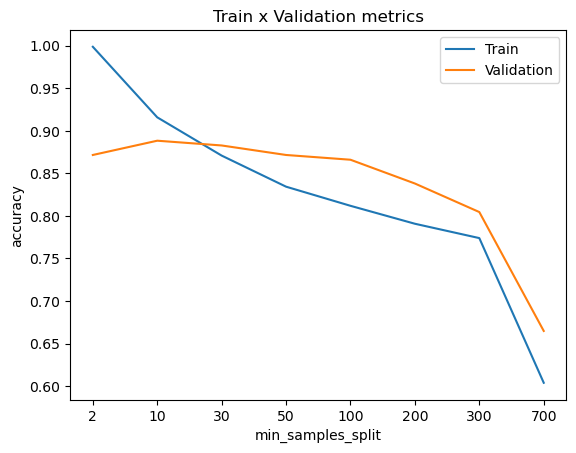

In [6]:
accuracy_list_train = []
accuracy_list_val = []
for min_samples_split in min_samples_split_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(min_samples_split = min_samples_split,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('min_samples_split')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(min_samples_split_list )),labels=min_samples_split_list) 
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

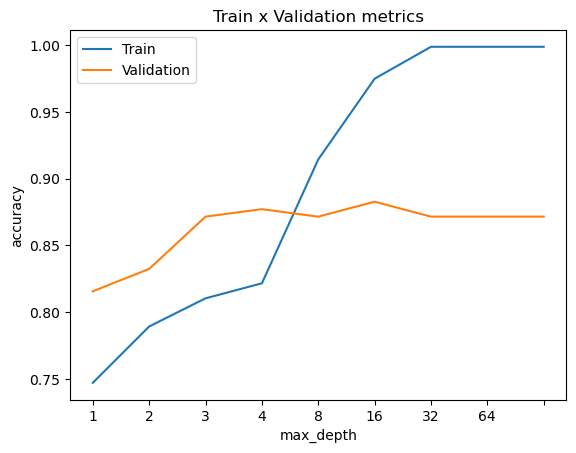

In [7]:
accuracy_list_train = []
accuracy_list_val = []
for max_depth in max_depth_list:
    # You can fit the model at the same time you define it, because the fit function returns the fitted estimator.
    model = RandomForestClassifier(max_depth = max_depth,
                                   random_state = RANDOM_STATE).fit(X_train,y_train) 
    predictions_train = model.predict(X_train) ## The predicted values for the train dataset
    predictions_val = model.predict(X_val) ## The predicted values for the test dataset
    accuracy_train = accuracy_score(predictions_train,y_train)
    accuracy_val = accuracy_score(predictions_val,y_val)
    accuracy_list_train.append(accuracy_train)
    accuracy_list_val.append(accuracy_val)

plt.title('Train x Validation metrics')
plt.xlabel('max_depth')
plt.ylabel('accuracy')
plt.xticks(ticks = range(len(max_depth_list )),labels=max_depth_list)
plt.plot(accuracy_list_train)
plt.plot(accuracy_list_val)
plt.legend(['Train','Validation'])

In [8]:
random_forest_model = RandomForestClassifier(n_estimators = 100,
                                             max_depth = 16, 
                                             min_samples_split = 10).fit(X_train,y_train)
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(random_forest_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9115
Metrics test:
	Accuracy score: 0.8771


In [9]:
n = int(len(X_train)*0.8) ## Let's use 80% to train and 20% to eval
X_train_fit, X_train_eval, y_train_fit, y_train_eval = X_train[:n], X_train[n:], y_train[:n], y_train[n:]

In [10]:
# xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.01,verbosity = 0, early_stopping_rounds = 10)
# xgb_model.fit(X_train_fit,y_train_fit, eval_set = [(X_train_eval,y_train_eval)])

In [11]:
# print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val),y_val):.4f}")

In [12]:
missing_features = ['Title_Capt', 'Title_Don', 'Title_Jonkheer', 'Title_Lady', 'Title_Major', 'Title_Mlle', 'Title_Mme', 'Title_Sir', 'Title_the Countess', 'Deck_T', 'Ticket_item_A/4.', 'Ticket_item_A/S', 'Ticket_item_A4.', 'Ticket_item_C.A./SOTON', 'Ticket_item_Fa', 'Ticket_item_P/PP', 'Ticket_item_S.C./A.4.', 'Ticket_item_S.O.P.', 'Ticket_item_S.P.', 'Ticket_item_S.W./PP', 'Ticket_item_SC/AH_Basle', 'Ticket_item_SCO/W', 'Ticket_item_SO/C', 'Ticket_item_SW/PP', 'Ticket_item_W/C', 'Ticket_item_WE/P']

for feat in missing_features:
    preprocessed_test_df[feat] = np.zeros(418, dtype=np.int8)

prediction = random_forest_model.predict(preprocessed_test_df[input_features])
submission = pd.DataFrame({'PassengerId': preprocessed_test_df['PassengerId'],'Survived': prediction.astype(int)})
submission.to_csv('/kaggle/working/submission.csv', index=False)